In [10]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat
import auxiliary_functions

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

In [11]:
net_heat = ContTempNetwork.load('fig3_growing_network300')

In [12]:
# Example matrices for demonstration
matrix1 = net_heat.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray()
matrix2 = net_heat.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray()
matrix3 = net_heat.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray()

# Define the time intervals for the x-axis
time_intervals = [(0, 100), (100, 200), (200, 300)]

In [13]:
selected_lamdas = np.logspace(-3,1,10)
sample_times = list(np.arange(0, len(net_heat.times), 10))

In [14]:
Conditional_S_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/conditional_S_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys))[0]][0])

In [52]:
N = net_heat.num_nodes
H = lambda t: t*np.exp(-t) - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))
Hc = lambda t: - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))

In [16]:
from scipy.signal import argrelextrema

def find_local_maxima(array, window_size):
    """
    Find the indices of local maxima in a NumPy array based on a given neighborhood size.
    
    Parameters:
        array (np.ndarray): Input array.
        window_size (int): Size of the neighborhood to consider for determining local maxima.
    
    Returns:
        np.ndarray: Indices of the local maxima.
    """
    # Define the order (half the window size)
    order = window_size // 2
    
    # Find indices of local maxima
    local_maxima_indices = argrelextrema(array, comparator=np.greater, order=order)[0]
    
    return local_maxima_indices

/tmp/ipykernel_1885649/3135216814.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


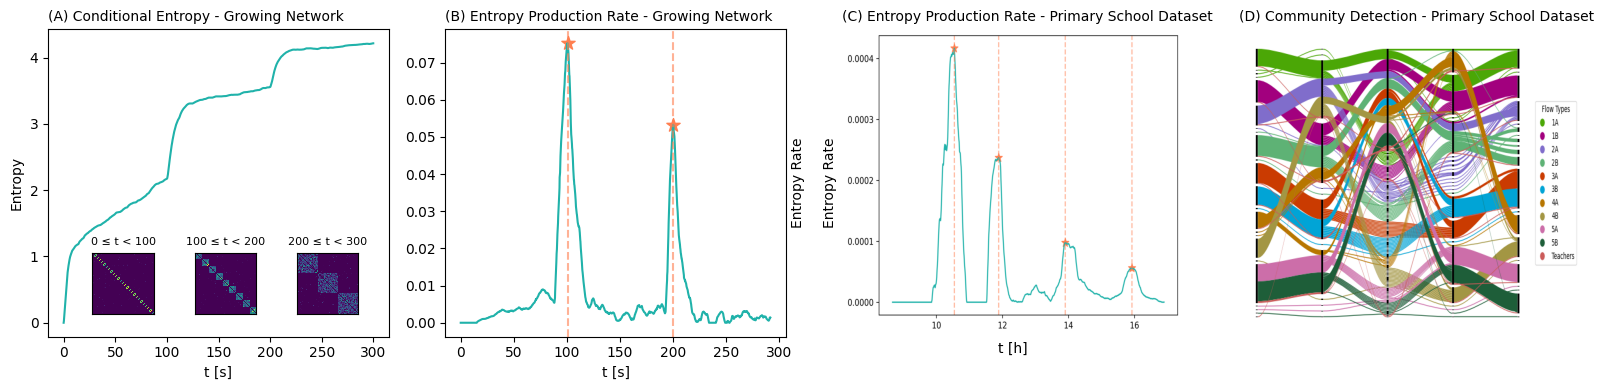

In [53]:
# Start creating the figure
fig = plt.figure(figsize=(16, 4))  # Wider figure for all plots in one row
gs = fig.add_gridspec(1, 4)  # Grid: 1 row, 4 columns

# Column 1: Plot A
ax_a = fig.add_subplot(gs[0, 0])
color = 'lightseagreen'
index = 5
smoothing_window = 50
S = Conditional_S_selected[index]

ax_a.plot(net_heat.times[sample_times], S, color=color, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(A) Conditional Entropy - Growing Network", loc='left', fontsize=10)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1, matrix2, matrix3]
positions = [0.10, 0.40, 0.70]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals[i][0]} ≤ t < {time_intervals[i][1]}", fontsize=8)

# Column 2: Plot B
ax_b = fig.add_subplot(gs[0, 1])
dS_dt = auxiliary_functions.derivative([s - Hc(s) for s in S], net_heat.times[sample_times])
dS_dt = auxiliary_functions.running_mean(dS_dt, smoothing_window)

local_window = 1000
maxima = find_local_maxima(np.array(dS_dt), local_window)

ax_b.plot(net_heat.times[sample_times][:-smoothing_window], np.maximum(0, dS_dt), color=color, alpha=1)
ax_b.scatter(net_heat.times[sample_times][maxima], np.maximum(0, dS_dt)[maxima], color="coral", marker="*", s=100, label="Local maxima")
for idx in maxima:
    ax_b.axvline(x=net_heat.times[sample_times][idx], color="coral", linestyle="--", alpha=0.6)

ax_b.set_xlabel("t [s]")
ax_b.set_ylabel("Entropy Rate")
ax_b.set_title("(B) Entropy Production Rate - Growing Network", loc='left', fontsize=10)
#ax_b.yaxis.tick_right()
ax_b.yaxis.set_label_position("right")

# Column 3: Plot C (Square aspect ratio)
signal_primaryschool = mpimg.imread('/home/b/skoove/Desktop/primary_school/netsci2025.png')

ax_c = fig.add_subplot(gs[0, 2])
ax_c.imshow(signal_primaryschool, aspect='auto')  # Ensure square shape
ax_c.set_xlabel("t [h]")
ax_c.set_ylabel("Entropy Rate")
ax_c.set_title("(C) Entropy Production Rate - Primary School Dataset", loc='left', fontsize=10)
ax_c.set_xticks([])
ax_c.set_yticks([])
ax_c.set_frame_on(False)

# Column 4: Plot D (Square aspect ratio)
sankey_primaryschool = mpimg.imread('/home/b/skoove/Desktop/primary_school/sankey_diagram_with_legend_sankeyflow.png')

ax_d = fig.add_subplot(gs[0, 3])
ax_d.imshow(sankey_primaryschool, aspect='auto')  # Ensure square shape
ax_d.set_title("(D) Community Detection - Primary School Dataset", loc='left', fontsize=10)
ax_d.set_xticks([])
ax_d.set_yticks([])
ax_d.set_frame_on(False)

# Adjust layout and display
plt.tight_layout()
#plt.savefig('/home/b/skoove/Desktop/growing300/figNetSci2025_row_squares.eps', format='eps', dpi=300)
plt.show()

#### Primary school plot

In [19]:
net_rw = ContTempNetwork.load('/home/b/skoove/Desktop/entropy/paper_data/socio_pat_primary_school/primaryschoolnet',
                              attributes_list=['node_to_label_dict',
                      'events_table',
                      'times',
                      'time_grid',
                      'num_nodes',
                      '_overlapping_events_merged',
                      'start_date',
                      'node_label_array',
                      'male_array',
                      'female_array',
                      'node_first_start_array',
                      'node_last_end_array',
                      'node_class_array',
                      'datetimes'])

In [20]:
import pandas as pd
df = pd.read_csv('../paper_data/socio_pat_primary_school/primaryschool.csv',
                 header=None, sep='\t', names=['time','id1','id2','class1','class2'])

In [21]:
df['hour'] = df['time'] // 3600
df['minute'] = (df['time'] % 3600) / 60

In [22]:
net_times_hours = net_rw.times / 3600
flag10 = np.argmax(net_times_hours > 10)
flag12 = np.argmax(net_times_hours > 12)
flag14 = np.argmax(net_times_hours > 14)
flag16 = np.argmax(net_times_hours > 16)
flagday1 = np.argmax(net_times_hours > 18)
print(flag10, flag12, flag14, flag16, flagday1)

240 600 960 1320 1556


In [23]:
lamdas_growing = np.logspace(-5,0,200)

In [24]:
multi_res_rw0_240 = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot0_240/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw0_240[lamda] = cluster
avg_nclusters_forw_rw0_240 = [np.mean([len(c) for c in \
                   multi_res_rw0_240[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw0_240 = [avg_norm_var_information(multi_res_rw0_240[lamda]) for lamda in lamdas_growing]

In [25]:
multi_res_rw240_600 = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot240_600/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw240_600[lamda] = cluster
avg_nclusters_forw_rw240_600 = [np.mean([len(c) for c in \
                   multi_res_rw240_600[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw240_600 = [avg_norm_var_information(multi_res_rw240_600[lamda]) for lamda in lamdas_growing]

In [26]:
multi_res_rw600_960 = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot600_960/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw600_960[lamda] = cluster
avg_nclusters_forw_rw600_960 = [np.mean([len(c) for c in \
                   multi_res_rw600_960[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw600_960 = [avg_norm_var_information(multi_res_rw600_960[lamda]) for lamda in lamdas_growing]

In [27]:
multi_res_rw960_1320 = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot960_1320/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw960_1320[lamda] = cluster
avg_nclusters_forw_rw960_1320 = [np.mean([len(c) for c in \
                   multi_res_rw960_1320[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw960_1320 = [avg_norm_var_information(multi_res_rw960_1320[lamda]) for lamda in lamdas_growing]

In [28]:
multi_res_rw960_1320 = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot960_1320/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw960_1320[lamda] = cluster
avg_nclusters_forw_rw960_1320 = [np.mean([len(c) for c in \
                   multi_res_rw960_1320[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw960_1320 = [avg_norm_var_information(multi_res_rw960_1320[lamda]) for lamda in lamdas_growing]

In [29]:
multi_res_rw1320_1556 = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/clustersplot1320_1556/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw1320_1556[lamda] = cluster
avg_nclusters_forw_rw1320_1556 = [np.mean([len(c) for c in \
                   multi_res_rw1320_1556[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw1320_1556 = [avg_norm_var_information(multi_res_rw1320_1556[lamda]) for lamda in lamdas_growing]

In [30]:
bestcluster0_240 = multi_res_rw0_240[lamdas_growing[170]][0]
bestcluster240_600 = multi_res_rw240_600[lamdas_growing[135]][0]
bestcluster600_960 = multi_res_rw600_960[lamdas_growing[180]][0]
bestcluster960_1320 = multi_res_rw960_1320[lamdas_growing[125]][0]
bestcluster1320_1556 = multi_res_rw1320_1556[lamdas_growing[90]][0]
bestclusters = [bestcluster0_240, bestcluster240_600, bestcluster600_960, bestcluster960_1320, bestcluster1320_1556]

#%% make data for flow diagram

source_comms = bestcluster0_240
target_comms = bestcluster240_600
class_dict = {clas : set(net_rw.node_array[net_rw.node_class_array == clas]) for \
                  clas in np.unique(net_rw.node_class_array)}

flows = []
for clas, clas_set in class_dict.items():
    for s, comm_s in enumerate(source_comms):
        for t, comm_t in enumerate(target_comms):
            val = len(clas_set.intersection(comm_s).intersection(comm_t))
            if val > 0:
                flows.append({'source': s, 'target': t, 'type': clas, 'value': val})

df_flows0_600 = pd.DataFrame.from_dict(flows)

#%% make data for flow diagram

source_comms = bestcluster240_600
target_comms = bestcluster600_960
class_dict = {clas : set(net_rw.node_array[net_rw.node_class_array == clas]) for \
                  clas in np.unique(net_rw.node_class_array)}

flows = []
for clas, clas_set in class_dict.items():
    for s, comm_s in enumerate(source_comms):
        for t, comm_t in enumerate(target_comms):
            val = len(clas_set.intersection(comm_s).intersection(comm_t))
            if val > 0:
                flows.append({'source': s, 'target': t, 'type': clas, 'value': val})

df_flows240_960 = pd.DataFrame.from_dict(flows)
 
#%% make data for flow diagram

source_comms = bestcluster600_960
target_comms = bestcluster960_1320
class_dict = {clas : set(net_rw.node_array[net_rw.node_class_array == clas]) for \
                  clas in np.unique(net_rw.node_class_array)}

flows = []
for clas, clas_set in class_dict.items():
    for s, comm_s in enumerate(source_comms):
        for t, comm_t in enumerate(target_comms):
            val = len(clas_set.intersection(comm_s).intersection(comm_t))
            if val > 0:
                flows.append({'source': s, 'target': t, 'type': clas, 'value': val})

df_flows600_1320 = pd.DataFrame.from_dict(flows)

#%% make data for flow diagram

source_comms = bestcluster960_1320
target_comms = bestcluster1320_1556
class_dict = {clas : set(net_rw.node_array[net_rw.node_class_array == clas]) for \
                  clas in np.unique(net_rw.node_class_array)}

flows = []
for clas, clas_set in class_dict.items():
    for s, comm_s in enumerate(source_comms):
        for t, comm_t in enumerate(target_comms):
            val = len(clas_set.intersection(comm_s).intersection(comm_t))
            if val > 0:
                flows.append({'source': s, 'target': t, 'type': clas, 'value': val})

df_flows960_1556 = pd.DataFrame.from_dict(flows)

In [31]:
df_flows0_600['target_label'] = df_flows0_600['target'] + int(np.max(df_flows0_600['source']) + 1)

df_flows240_960['source'] = df_flows240_960['source'] + int(np.max(df_flows0_600['source']) + 1)
df_flows240_960['target_label'] = df_flows240_960['target'] + int(np.max(df_flows240_960['source']) + 1)

df_flows600_1320['source'] = df_flows600_1320['source'] + int(np.max(df_flows240_960['source']) + 1)
df_flows600_1320['target_label'] = df_flows600_1320['target'] + int(np.max(df_flows600_1320['source']) + 1)

df_flows960_1556['source'] = df_flows960_1556['source'] + int(np.max(df_flows600_1320['source']) + 1)
df_flows960_1556['target_label'] = df_flows960_1556['target'] + int(np.max(df_flows960_1556['source']) + 1)

df_flows = pd.concat([df_flows0_600, df_flows240_960, df_flows600_1320, df_flows960_1556], ignore_index=True)

In [33]:
selected_lamdas = np.logspace(-5,0,10)

In [34]:
Conditional_S_selected_hr = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/primaryschoolnet_rw/conditional_S_selected_hr/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected_hr.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys))[0]][0])

/tmp/ipykernel_1885649/1634857990.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


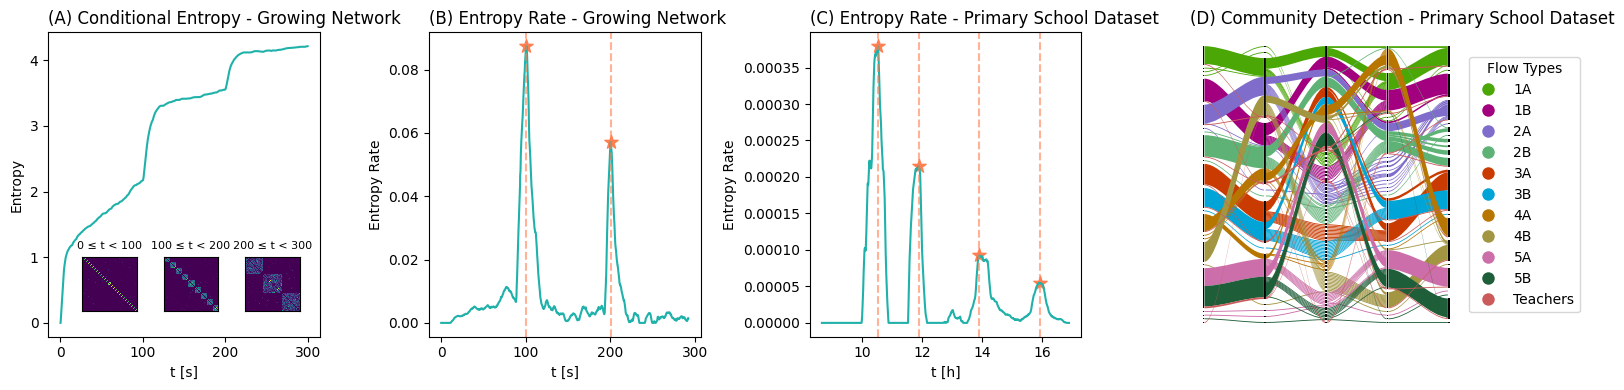

In [55]:
# Start creating the figure
fig = plt.figure(figsize=(16, 4))  # Wider figure for all plots in one row
gs = fig.add_gridspec(1, 4)  # Grid: 1 row, 4 columns

# Column 1: Plot A
ax_a = fig.add_subplot(gs[0, 0])
color = 'lightseagreen'
index = 5
smoothing_window = 50
S = Conditional_S_selected[index]

ax_a.plot(net_heat.times[sample_times], S, color=color, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(A) Conditional Entropy - Growing Network", loc='left', fontsize=12)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1, matrix2, matrix3]
positions = [0.10, 0.40, 0.70]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals[i][0]} ≤ t < {time_intervals[i][1]}", fontsize=8)

# Column 2: Plot B

N = net_heat.num_nodes
H = lambda t: t*np.exp(-t) - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))
Hc = lambda t: - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))


ax_b = fig.add_subplot(gs[0, 1])
dS_dt = auxiliary_functions.derivative([s - H(s) for s in S], net_heat.times[sample_times])
dS_dt = auxiliary_functions.running_mean(dS_dt, smoothing_window)

local_window = 1000
maxima = find_local_maxima(np.array(dS_dt), local_window)

ax_b.plot(net_heat.times[sample_times][:-smoothing_window], np.maximum(0, dS_dt), color=color, alpha=1)
ax_b.scatter(net_heat.times[sample_times][maxima], np.maximum(0, dS_dt)[maxima], color="coral", marker="*", s=100, label="Local maxima")
for idx in maxima:
    ax_b.axvline(x=net_heat.times[sample_times][idx], color="coral", linestyle="--", alpha=0.6)

ax_b.set_xlabel("t [s]")
ax_b.set_ylabel("Entropy Rate")
ax_b.set_title("(B) Entropy Rate - Growing Network", loc='left', fontsize=12)


# Column 3: Plot C (Square aspect ratio)
N = net_rw.num_nodes
H = lambda t: t*np.exp(-t) - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))
Hc = lambda t: - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))


color = 'lightseagreen'
index = 5

smoothing_window = 75
lamda = selected_lamdas[index]

S = Conditional_S_selected_hr[index]
dS_dt = auxiliary_functions.derivative([S[i] - Hc(t) for i,t in enumerate(net_times_hours[1:1557] - net_times_hours[0])],  net_rw.times[1:(1557)])
dS_dt = auxiliary_functions.running_mean(dS_dt, smoothing_window)

local_window = 250
maxima = find_local_maxima(np.array(dS_dt), local_window)
maxima += 0

ax_c = fig.add_subplot(gs[0, 2])
ax_c.plot(net_times_hours[:1556- (smoothing_window)], np.maximum(0,dS_dt), color = color, alpha = 1)
ax_c.scatter(net_times_hours[maxima], np.maximum(0,dS_dt)[maxima], color="coral", marker="*", s=100, label="Local maxima")  # Add stars at local maxima
for idx in maxima:
    ax_c.axvline(x=net_times_hours[idx], color="coral", linestyle="--", alpha=0.6)  # Add vertical lines 
ax_c.set_xlabel("t [h]")
ax_c.set_ylabel("Entropy Rate")
ax_c.set_title("(C) Entropy Rate - Primary School Dataset", loc='left', fontsize=12)


# Column 4: Plot D (Square aspect ratio)
from sankeyflow import Sankey

# Sample data
list_value = df_flows['value'].copy()
list_value[df_flows['value'] == 1] = 1

# Define the nodes and flows
nodes = [
    [(node, df_flows0_600[df_flows0_600['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows0_600['source'].unique()],
    [(node, df_flows240_960[df_flows240_960['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows240_960['source'].unique()],
    [(node, df_flows600_1320[df_flows600_1320['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows600_1320['source'].unique()],
    [(node, df_flows960_1556[df_flows960_1556['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows960_1556['source'].unique()],
    [(node, df_flows960_1556[df_flows960_1556['target_label'] == node]['value'].sum(), dict(color="black")) for node in df_flows960_1556['target_label'].unique()],
    #[(label_mapping[node], df_flows[df_flows['target'] == node]['value'].sum()) for node in df_flows['target_label'].unique()]
]


# Define colors for each link
color_list = [
    "#4ba706", "#a2007e", "#806dcb", "#5eb275", "#ca3b01",
    "#01a4d6", "#b77600", "#a39643", "#cc6ea9", "#1e5e39", "#cb5b5a"
]

dict_color = {df_type: color_list[i] for i, df_type in enumerate(df_flows['type'].unique())}
link_colors = [dict_color[df_flows['type'][i]] for i in range(df_flows.shape[0])]

flows = [(df_flows['source'][index], df_flows['target_label'][index], df_flows['value'][index], {'color': link_colors[index]}) for index in df_flows.index]

ax_d = fig.add_subplot(gs[0, 3])
s = Sankey(flows=flows, nodes=nodes, node_opts=dict(label_format=''))

# Draw the Sankey diagram
s.draw()

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dict_color[df_type], markersize=10)
           for df_type in df_flows['type'].unique()]

ax_d.legend(handles, df_flows['type'].unique(), title='Flow Types', loc='center left', bbox_to_anchor=(1, 0.5))
ax_d.set_title("(D) Community Detection - Primary School Dataset", loc='left', fontsize=12)
ax_d.set_xticks([])
ax_d.set_yticks([])
ax_d.set_frame_on(False)

# Adjust layout and display
plt.tight_layout()
plt.savefig('/home/b/skoove/Desktop/growing300/figNetSci2025_row_squares.eps', format='eps', dpi=300)
plt.show()

/tmp/ipykernel_1885649/2154310486.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


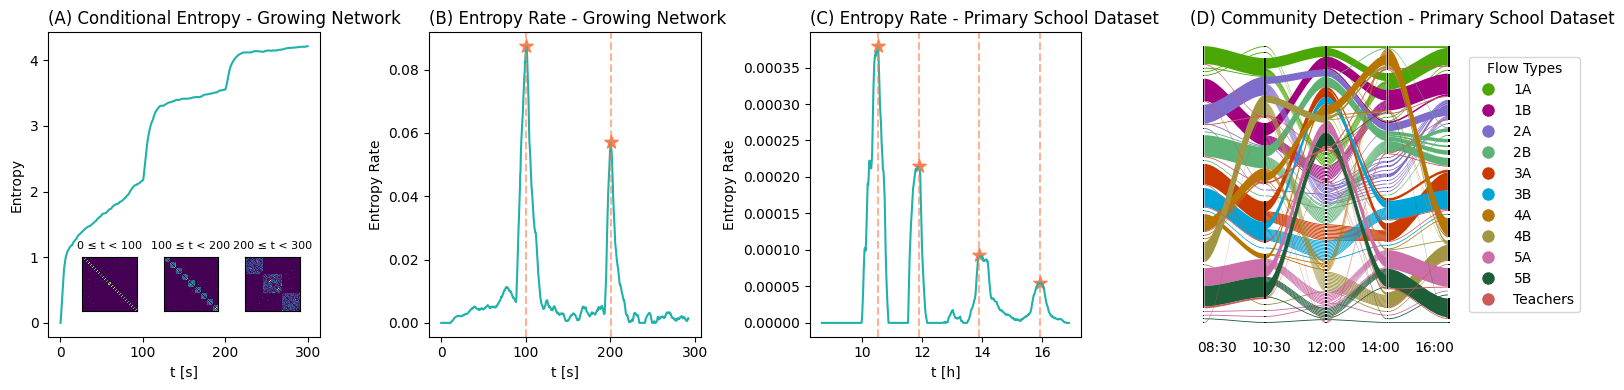

In [78]:
# Start creating the figure
fig = plt.figure(figsize=(16, 4))  # Wider figure for all plots in one row
gs = fig.add_gridspec(1, 4)  # Grid: 1 row, 4 columns

# Column 1: Plot A
ax_a = fig.add_subplot(gs[0, 0])
color = 'lightseagreen'
index = 5
smoothing_window = 50
S = Conditional_S_selected[index]

ax_a.plot(net_heat.times[sample_times], S, color=color, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(A) Conditional Entropy - Growing Network", loc='left', fontsize=12)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1, matrix2, matrix3]
positions = [0.10, 0.40, 0.70]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals[i][0]} ≤ t < {time_intervals[i][1]}", fontsize=8)

# Column 2: Plot B

N = net_heat.num_nodes
H = lambda t: t*np.exp(-t) - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))
Hc = lambda t: - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))


ax_b = fig.add_subplot(gs[0, 1])
dS_dt = auxiliary_functions.derivative([s - H(s) for s in S], net_heat.times[sample_times])
dS_dt = auxiliary_functions.running_mean(dS_dt, smoothing_window)

local_window = 1000
maxima = find_local_maxima(np.array(dS_dt), local_window)

ax_b.plot(net_heat.times[sample_times][:-smoothing_window], np.maximum(0, dS_dt), color=color, alpha=1)
ax_b.scatter(net_heat.times[sample_times][maxima], np.maximum(0, dS_dt)[maxima], color="coral", marker="*", s=100, label="Local maxima")
for idx in maxima:
    ax_b.axvline(x=net_heat.times[sample_times][idx], color="coral", linestyle="--", alpha=0.6)

ax_b.set_xlabel("t [s]")
ax_b.set_ylabel("Entropy Rate")
ax_b.set_title("(B) Entropy Rate - Growing Network", loc='left', fontsize=12)


# Column 3: Plot C (Square aspect ratio)
N = net_rw.num_nodes
H = lambda t: t*np.exp(-t) - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))
Hc = lambda t: - (1-np.exp(-t))*(np.log(1-np.exp(-t)) - np.log(N))


color = 'lightseagreen'
index = 5

smoothing_window = 75
lamda = selected_lamdas[index]

S = Conditional_S_selected_hr[index]
dS_dt = auxiliary_functions.derivative([S[i] - Hc(t) for i,t in enumerate(net_times_hours[1:1557] - net_times_hours[0])],  net_rw.times[1:(1557)])
dS_dt = auxiliary_functions.running_mean(dS_dt, smoothing_window)

local_window = 250
maxima = find_local_maxima(np.array(dS_dt), local_window)
maxima += 0

ax_c = fig.add_subplot(gs[0, 2])
ax_c.plot(net_times_hours[:1556- (smoothing_window)], np.maximum(0,dS_dt), color = color, alpha = 1)
ax_c.scatter(net_times_hours[maxima], np.maximum(0,dS_dt)[maxima], color="coral", marker="*", s=100, label="Local maxima")  # Add stars at local maxima
for idx in maxima:
    ax_c.axvline(x=net_times_hours[idx], color="coral", linestyle="--", alpha=0.6)  # Add vertical lines 
ax_c.set_xlabel("t [h]")
ax_c.set_ylabel("Entropy Rate")
ax_c.set_title("(C) Entropy Rate - Primary School Dataset", loc='left', fontsize=12)


# Column 4: Plot D (Square aspect ratio)
from sankeyflow import Sankey

# Sample data
list_value = df_flows['value'].copy()
list_value[df_flows['value'] == 1] = 1

# Define the nodes and flows
nodes = [
    [(node, df_flows0_600[df_flows0_600['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows0_600['source'].unique()],
    [(node, df_flows240_960[df_flows240_960['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows240_960['source'].unique()],
    [(node, df_flows600_1320[df_flows600_1320['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows600_1320['source'].unique()],
    [(node, df_flows960_1556[df_flows960_1556['source'] == node]['value'].sum(), dict(color="black")) for node in df_flows960_1556['source'].unique()],
    [(node, df_flows960_1556[df_flows960_1556['target_label'] == node]['value'].sum(), dict(color="black")) for node in df_flows960_1556['target_label'].unique()],
]

# Define colors for each link
color_list = [
    "#4ba706", "#a2007e", "#806dcb", "#5eb275", "#ca3b01",
    "#01a4d6", "#b77600", "#a39643", "#cc6ea9", "#1e5e39", "#cb5b5a"
]

dict_color = {df_type: color_list[i] for i, df_type in enumerate(df_flows['type'].unique())}
link_colors = [dict_color[df_flows['type'][i]] for i in range(df_flows.shape[0])]

flows = [(df_flows['source'][index], df_flows['target_label'][index], df_flows['value'][index], {'color': link_colors[index]}) for index in df_flows.index]

# Adjust the Sankey diagram and add a custom x-axis
ax_d = fig.add_subplot(gs[0, 3])
s = Sankey(flows=flows, nodes=nodes, node_opts=dict(label_format=''))

# Draw the Sankey diagram
s.draw()

# Add custom x-axis labels manually
time_labels = ["08:30", "10:30", "12:00", "14:00", "16:00"]
x_positions = [0.1, 0.3, 0.5, 0.7, 0.9]  # Adjust based on diagram layout

# Add labels using ax.text for precise control
for x_pos, label in zip(x_positions, time_labels):
    ax_d.text(x_pos, -0.05, label, fontsize=10, ha='center', transform=ax_d.transAxes)


# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dict_color[df_type], markersize=10)
           for df_type in df_flows['type'].unique()]


ax_d.legend(handles, df_flows['type'].unique(), title='Flow Types', loc='center left', bbox_to_anchor=(1, 0.5))
ax_d.set_title("(D) Community Detection - Primary School Dataset", loc='left', fontsize=12)
ax_d.set_yticks([])
ax_d.set_frame_on(False)

# Adjust layout and display
plt.tight_layout()
#plt.savefig('/home/b/skoove/Desktop/growing300/figNetSci2025_row_squares.eps', format='eps', dpi=300)
plt.show()